In [165]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import torch 
import torchvision
from PIL import Image
import json
import datetime
from torchvision.transforms import transforms 
from torchvision.utils import make_grid
import torch.nn as nn
import time
import copy
import torchvision.models as models
from torchvision.utils import save_image
import torch.nn.functional as F

from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

#resnet = models.resnet18(pretrained=True)


In [166]:
from roofnet.utils.data import ImageDataset
from torchvision.transforms import transforms 

data_file_path = '/home/misha/research/qrithm/roofnet/data/labeled_dataset.npy'
transform_chain = transforms.Compose([
                        #transforms.Grayscale(),
                        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0),
                        transforms.ToTensor(),
                        transforms.Normalize([0.,0.,0,], [1.,1.,1.]),   
                        
                            ])
data = ImageDataset(data_file_path, 
                    pillow=True,
                    transform=transform_chain)
dataloader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)
len(data), len(dataloader)

Loading data
Done loading data


(420, 14)

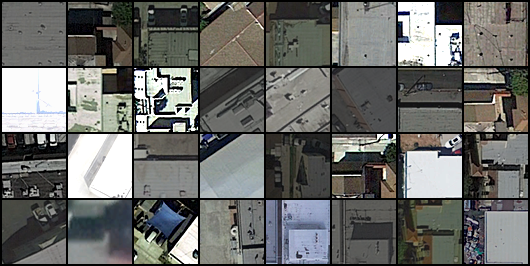

In [167]:
# Fixed input for debugging
fixed_x = next(iter(dataloader))
fixed_x = fixed_x[0]
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [168]:
image_channels = fixed_x.size(1)
img_dim = fixed_x.size(-1)

In [169]:
from roofnet.models.vae import VAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE(img_dim=img_dim,image_channels=image_channels,z_dim=128,device=device).to(device)
#model.load_state_dict(torch.load('vae.torch', map_location='cpu'))

In [170]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

In [171]:
def loss_fn(recon_x, x, mu, logvar,beta=1.0):
    x = x.to(device)
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    KLD*=beta
    return BCE + KLD, BCE, KLD

In [172]:
!rm -rfr reconstructed
!mkdir reconstructed

# Train VAE

In [176]:
filename = '/home/misha/research/qrithm/roofnet/saved_models/roofnet.pth'
epochs = 50
bs=32
train = True 
if train:
    epoch = 0
    while epoch < epochs:
        
        for idx in range(100):
            images = next(iter(dataloader))
            images = images[0]
            recon_images,z, mu, logvar = model(images.to(device))
            loss, bce, kld = loss_fn(recon_images, images, mu, logvar,beta=1.0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                    epochs, loss.item()/bs, bce.item()/bs, kld.item()/bs)
        epoch+=1
        print(to_print)
        

    # notify to android when finished training
    #notify(to_print, priority=1)

    torch.save(model.state_dict(),  filename)

Epoch[1/50] Loss: 7665.030 7664.981 0.049
Epoch[2/50] Loss: 7411.905 7411.811 0.094
Epoch[3/50] Loss: 7248.042 7247.923 0.119
Epoch[4/50] Loss: 7325.563 7325.447 0.117
Epoch[5/50] Loss: 6843.115 6842.957 0.159
Epoch[6/50] Loss: 7228.923 7228.785 0.138
Epoch[7/50] Loss: 7203.277 7203.135 0.142
Epoch[8/50] Loss: 6940.207 6940.051 0.156
Epoch[9/50] Loss: 6664.847 6664.666 0.181
Epoch[10/50] Loss: 6934.541 6934.385 0.156
Epoch[11/50] Loss: 6959.395 6959.241 0.154
Epoch[12/50] Loss: 6065.988 6065.754 0.234
Epoch[13/50] Loss: 7087.624 7087.463 0.160
Epoch[14/50] Loss: 6729.891 6729.684 0.207
Epoch[15/50] Loss: 6671.205 6671.012 0.192
Epoch[16/50] Loss: 6828.909 6828.740 0.170
Epoch[17/50] Loss: 6845.763 6845.560 0.203
Epoch[18/50] Loss: 6542.181 6541.967 0.214
Epoch[19/50] Loss: 6785.792 6785.592 0.199
Epoch[20/50] Loss: 6967.739 6967.558 0.181
Epoch[21/50] Loss: 6555.785 6555.562 0.224
Epoch[22/50] Loss: 6369.717 6369.501 0.215
Epoch[23/50] Loss: 6436.740 6436.503 0.237
Epoch[24/50] Loss: 6

In [128]:
def compare(x):
    x=x.to(device)
    recon_x,_, _, _ = model(x)
    return torch.cat([x, recon_x])

# Compare real image and reconstruction

Note: VAEs are known to generate blurry. The reason is that the latent code is trying to compress as much info as possible and only focus on the meaningful features.

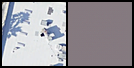

In [175]:

fixed_x = next(iter(dataloader))[0][:1]
compare_x = compare(fixed_x)

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))

In [151]:
dataloader = torch.utils.data.DataLoader(data, batch_size=7, shuffle=False)
dataloader = iter(dataloader)

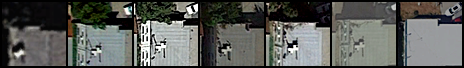

In [160]:
images = next(dataloader)[0]
save_image(images, 'real_image.png')

Image('real_image.png')

[15.299944, 13.107702, 13.1089115, 11.746007, 14.324351, 3.5717206, 8.83796]


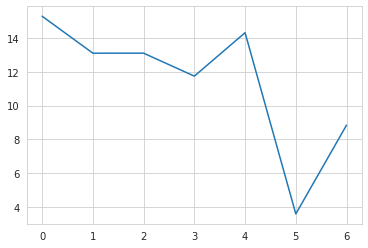

In [161]:
recon_images,z, mu, logvar = model(images.to(device))
z =z.detach().cpu().numpy()
d1 = [np.linalg.norm(zt) for zt in z]

d2 = [np.linalg.norm(zi-zj) for zi,zj in zip(z[1:],z[:-1])]
print(d1)
sns.set_style('whitegrid')
plt.plot(d1)
#plt.plot(d2)


# Appendix

Code below is not actually being used for anything

In [34]:

class CPC(nn.Module):

    def __init__(self,
                 z_dim=128,
                 cpc_batch=3,
                 batch_size=1,
                 loader=None,
                 gpu_id=0,
                 rescale=1000.0,
                 ):
        super(CPC, self).__init__()

        self.z_dim = z_dim
        self.cpc_batch = cpc_batch
        self.batch_size = batch_size
        self.loader = loader
        self.rescale = rescale
        self._check_inputs()

        self.z_dim = z_dim

        self.device = torch.device(
            "cuda:"+str(gpu_id)) if torch.cuda.is_available() else torch.device("cpu")

        self.W = nn.Parameter(torch.rand(z_dim, z_dim), requires_grad=True)

    def _check_inputs(self):
        assert self.z_dim is not None
        assert self.cpc_batch is not None
        assert self.batch_size is not None
        assert self.loader is not None

    def encode(self, x):
        return x

    def loss(self, x, x_next):
        # Same as density
        assert x_next.size(0) == x.size(0)
        z = self.encode(x)
        z_next = self.encode(x_next)
        # z = z.unsqueeze(2)  # bs x z_dim x 1
        #z_next = z_next.unsqueeze(2)
        w = self.W

        w = w.expand(x.shape[0], w.shape[0], w.shape[1])

        f_out = torch.bmm(torch.bmm(z_next, w), z.permute(0, 2, 1))
        f_out = f_out.squeeze()
        f_out /= self.rescale

        f_pos = f_out[:, :1]

        loss = log_sum_exp(f_out) - torch.log(torch.exp(f_pos))
        #print('neg',log_sum_exp(f_out))
        #print('pos',torch.log(torch.exp(f_pos)))

        #assert False 
        return torch.mean(loss), None

    def forward(self, z1, z2):
        z1 = z1.view(128, 1)
        z2 = z2.view(-1, 128)
        return torch.exp(torch.matmul(torch.matmul(z2, self.W), z1).squeeze(0)/self.rescale)


In [38]:
from roofnet.utils.data import ImageDataset, TripletBuildingSampler
from torchvision.transforms import transforms 

gpu_id = 0 
device = torch.device("cuda:"+str(gpu_id)) if torch.cuda.is_available() else torch.device("cpu")

data_file_path = '/home/misha/downloads/roofnet/data/small_dataset.npy'
data = ImageDataset(data_file_path, 
                    transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ]))

sampler = TripletBuildingSampler(data,batch_size=1)
loader = torch.utils.data.DataLoader(data, sampler=sampler,batch_size=3)
loaders = {'train':loader,'val':loader}
cpc = CPC(z_dim=128,
          cpc_batch=3,
          batch_size=1,
          gpu_id=gpu_id,
          loader=loader).to(device)

optimizer = torch.optim.Adam(cpc.parameters(), lr=3e-4)

model = nn.Sequential(resnet, cpc)


Loading data
Done loading data


In [50]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels,meta in dataloaders[phase]:
            
                print(inputs.shape,labels,meta)
                assert False 
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [51]:
train_model(model,loaders,cpc.loss,optimizer)

Epoch 0/24
----------
torch.Size([3, 3, 32, 64]) tensor([2015, 2013, 2018]) {'transition_year': tensor([2019, 2019, 2019]), 'address': ['5431 W 104th St, Los Angeles, CA 90045, USA', '5431 W 104th St, Los Angeles, CA 90045, USA', '5431 W 104th St, Los Angeles, CA 90045, USA']}


AssertionError: 